# Zadanie 15.5

 Wybierz zbiór danych z tych, które wykorzystywane były w module o regresji lub klasyfikacji. Dla któregoś z tych zbiorów stwórz Pipeline, w którym zawrzesz proces przygotowania danych i naucz nowy model, porównując go z tymi stworzonymi w tamtych modułach.

##### Załadowanie bibliotek

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

from sklearn.linear_model import ElasticNet

import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score


##### Załadowanie danych

In [3]:
bike_data = pd.read_csv('daily-bike-share.csv')
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82


##### Podział na `X`, `y`, `cyclical_features`, `nominal_features` i `numeric_features` oraz `train_test_split`

In [4]:
X = bike_data.drop(['rentals'], axis=1).copy()
y = bike_data['rentals'].copy()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
cyclical_features = ['season', 'mnth', 'weekday']
nominal_features = ['weathersit', 'holiday', 'workingday']

##### Stworzenie `SineCosineTransformer` i `DifferenceTempTransformer`

In [7]:
class SineCosineTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def _get_period(self, X, column):
        return X[column].nunique()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        for column in self.columns:
            period = self._get_period(X_transformed, column)
            X_transformed[f'{column}_sin'] = np.sin(2 * np.pi * X_transformed[column] / period)
            X_transformed[f'{column}_cos'] = np.cos(2 * np.pi * X_transformed[column] / period)
        X_transformed.drop(columns=self.columns, inplace=True)
        return X_transformed

In [8]:
class DifferenceTempTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, atemp_col='atemp', temp_col='temp', new_col='difference_temp'):
        self.atemp_col = atemp_col
        self.temp_col = temp_col
        self.new_col = new_col

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed[self.new_col] = np.where(
            X_transformed[self.temp_col] != 0,
            (X_transformed[self.atemp_col] - X_transformed[self.temp_col]) / X_transformed[self.temp_col],
            0
        )
        X_transformed.drop(columns=[self.atemp_col], inplace=True)
        return X_transformed

##### Stworzenie `Pipeline`

In [9]:
cyclical_features_prep = Pipeline(steps=[
    ('sine_cosine', SineCosineTransformer(columns=cyclical_features))
])

nominal_features_prep = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder(drop='first', sparse_output=False))
])

numeric_features_prep = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())
])

data_preparation = ColumnTransformer(transformers=[
    ('cyclical_preprocessing', cyclical_features_prep, cyclical_features),
    ('nominal_preprocessing', nominal_features_prep, nominal_features),
    ('numeric_features', numeric_features_prep, numeric_features)
])

##### Funkcja do ewaluacji modelu

In [10]:
def evaluate_and_visualize(y_true, y_pred, X_test):

    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Calculate Adjusted R²
    n = len(y_true)  # Number of observations
    p = X_test.shape[1]  # Number of predictors
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Print metrics
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Adjusted R²: {r2_adj:.4f}")

    # Visualization: Actual vs. Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.7, color='blue', edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.title('Actual vs. Predicted Values', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

##### Model z modułu 13.5

In [11]:
model_13_5 = Pipeline(steps=[
    ('data_preparation', data_preparation),
    ('model', ElasticNet(alpha=0.1, l1_ratio=0.4, random_state=42))
])

# Ustawienie parametru degree=1 w preprocessorze zgodnie z modułem 13.5
model_13_5.set_params(data_preparation__numeric_features__polynomialfeatures__degree=1)


Pipeline(steps=[('data_preparation',
                 ColumnTransformer(transformers=[('cyclical_preprocessing',
                                                  Pipeline(steps=[('sine_cosine',
                                                                   SineCosineTransformer(columns=['season',
                                                                                                  'mnth',
                                                                                                  'weekday']))]),
                                                  ['season', 'mnth',
                                                   'weekday']),
                                                 ('nominal_preprocessing',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['weathersit', 'holiday',
                                                   'workingday']),
                                                 ('numeric_features',
                                                  Pipeline(steps=[('logtransformer',
                                                                   PowerTransformer()),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(degree=1))]),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed'])])),
                ('model',
                 ElasticNet(alpha=0.1, l1_ratio=0.4, random_state=42))])

##### Trenowanie, Predykcja oraz Ewaluacja i Wizualizacja Modelu 13.5

RMSE: 539.9715
MAE: 386.3656
R²: 0.4082
Adjusted R²: 0.3504


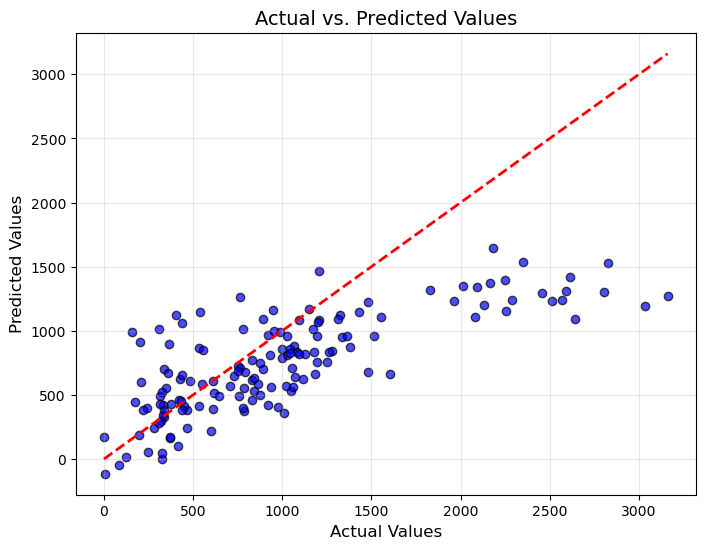

In [12]:
model_13_5.fit(X_train, y_train)

y_pred_model_13_5 = model_13_5.predict(X_test)

evaluate_and_visualize(y_test, y_pred_model_13_5, X_test)

Podsumowanie:
Stworzyłem bazowy rurociąg i użyłem parametrów z modułu 13.5.

Wypadł gorzej, niż w tamtym module. (RMSE: 483.9379418443879)

Jest to zrozumiałe - inaczej podzieliłem cechy. W oryginale cechy podzielone były tylko na numeryczne i kategoryczne.

Ja w rurociągu podzieliłem cechy na nominalne, numeryczne i cykliczne.

Mam nadzieję, że przy innych parametrach mój pipeline będzie miał lepsze wyniki z uwagi na rozróżnienie cech również na cykliczne i nominalne.

Poeksperymentuję też z innymi modelami niż ElasticNet()

(SVR? XGBoost?)

Ale to w kolejnym zadaniu, które zakłada użycie GridSearch. ;) CDN... 